# Hello Bluesky: Reading detectors and scanning

In this notebook you will:

* Connect to some simulated hardware.
* Acquire some data via two common experimental procedures ("plans"), ``count`` and ``scan``.
* Write a custom plan.

Recommend Prerequisites:

* [Hello Python and Jupyter](./Hello%20Python%20and%20Jupyter.ipynb)

## Configuration
Below, we will connect to EPICS IOC(s) controlling simulated hardware in lieu of actual motors, detectors. The IOCs should already be running in the background. Run this command to verify that they are running: it should produce output with RUNNING on each line. In the event of a problem, edit this command to replace `status` with `restart all` and run again.

In [1]:
%matplotlib widget

In [2]:
!supervisorctl -c supervisor/supervisord.conf status

decay                            RUNNING   pid 4925, uptime 0:00:18
mini_beamline                    RUNNING   pid 4926, uptime 0:00:18
random_walk                      RUNNING   pid 4927, uptime 0:00:18
random_walk_horiz                RUNNING   pid 4928, uptime 0:00:18
random_walk_vert                 RUNNING   pid 4929, uptime 0:00:18
simple                           RUNNING   pid 4930, uptime 0:00:18
thermo_sim                       RUNNING   pid 4931, uptime 0:00:18
trigger_with_pc                  RUNNING   pid 4932, uptime 0:00:18


In [3]:
%run scripts/beamline_configuration.py

In [4]:
# aliases for convenience/readability
motor = motor_ph
det = ph

Check that we can communicate with the hardware. If this doesn't raise an error, it worked.

In [5]:
det.wait_for_connection()

## Data Acquisition

### Executing a `count` plan with various parameters

In [6]:
RE(count([det]))



Transient Scan ID: 1     Time: 2020-05-08 20:55:47
Persistent Unique Scan ID: '1b3e6c84-4931-4684-995e-de213ab3d87f'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 20:55:47.0 |      96932 |
+-----------+------------+------------+
generator count ['1b3e6c84'] (scan num: 1)





('1b3e6c84-4931-4684-995e-de213ab3d87f',)

The return value is a list of the run IDs that uniquely identify this data set. The "scan num" is easier to remember but is not good for long-term reference because it may not be unique.

Let's looks at the documentation for `count` to see what our other options are.

In [7]:
help(count)  # or, equiavently, type count? or ?count

Help on function count in module bluesky.plans:

count(detectors, num=1, delay=None, *, per_shot=None, md=None)
    Take one or more readings from detectors.
    
    Parameters
    ----------
    detectors : list
        list of 'readable' objects
    num : integer, optional
        number of readings to take; default is 1
    
        If None, capture data until canceled
    delay : iterable or scalar, optional
        Time delay in seconds between successive readings; default is 0.
    per_shot : callable, optional
        hook for customizing action of inner loop (messages per step)
        Expected signature ::
    
           def f(detectors: Iterable[OphydObj]) -> Generator[Msg]:
               ...
    
    md : dict, optional
        metadata
    
    Notes
    -----
    If ``delay`` is an iterable, it must have at least ``num - 1`` entries or
    the plan will raise a ``ValueError`` during iteration.



In [8]:
# Creating a figure explicitly in advance helps with the
# top-to-bottom flow of this notebook, but it is not necessary.
# If this is omitted, bluesky will cause a figure to appear
# during the RE(...) execution below.
plt.figure('ph_det vs time')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 640x480 with 0 Axes>

In [9]:
# five consecutive readings
RE(count([det], num=5))



Transient Scan ID: 2     Time: 2020-05-08 20:55:47
Persistent Unique Scan ID: 'ed91f326-923d-424e-8d8b-15c0a09bcd9c'
New stream: 'primary'


+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 20:55:47.3 |      95256 |
|         2 | 20:55:47.3 |      95175 |
|         3 | 20:55:47.3 |      95347 |
|         4 | 20:55:47.3 |      95629 |
|         5 | 20:55:47.3 |      95834 |


+-----------+------------+------------+
generator count ['ed91f326'] (scan num: 2)





('ed91f326-923d-424e-8d8b-15c0a09bcd9c',)

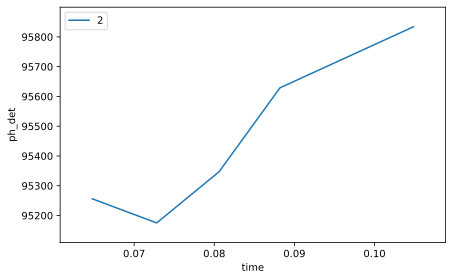

In [10]:
plt.gcf()  # Display a snapshot of the current state of the figure.

In [11]:
plt.gcf().canvas  # To avoid needing to scroll up, display the interactive canvas again here.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
# five sequential readings separated by a 1-second delay
RE(count([det], num=5, delay=1))



Transient Scan ID: 3     Time: 2020-05-08 20:55:47
Persistent Unique Scan ID: 'bd355c1f-47a1-4535-8136-310fac0983e2'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 20:55:47.9 |      96033 |


|         2 | 20:55:48.9 |     102419 |


|         3 | 20:55:49.9 |     103970 |


|         4 | 20:55:50.9 |      97736 |


|         5 | 20:55:51.9 |      96186 |


+-----------+------------+------------+
generator count ['bd355c1f'] (scan num: 3)





('bd355c1f-47a1-4535-8136-310fac0983e2',)

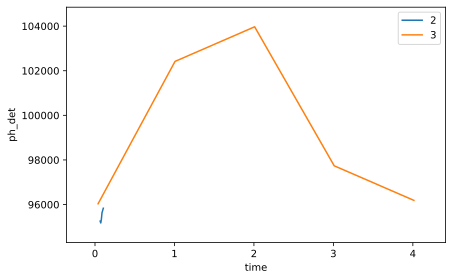

In [13]:
plt.gcf()  # Display a snapshot of the current state of the figure.

### Scan

Scan ``motor`` from -10 to 10, stopping at 15 equally-spaced points along the way and reading ``det``.

In [14]:
# Creating a figure explicitly in advance helps with the
# top-to-bottom flow of this notebook, but it is not necessary.
# If this is omitted, bluesky will cause a figure to appear
# during the RE(...) execution below.
plt.figure('ph_det vs motor_ph')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 640x480 with 0 Axes>

In [15]:
RE(scan([det], motor, -10, 10, 15))



Transient Scan ID: 4     Time: 2020-05-08 20:55:53
Persistent Unique Scan ID: '1b44cb80-47c6-479f-9e56-793a1bc11655'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 20:55:53.5 |    -10.000 |      14263 |
|         2 | 20:55:53.5 |     -8.571 |      24105 |
|         3 | 20:55:53.6 |     -7.143 |      38070 |
|         4 | 20:55:53.6 |     -5.714 |      54330 |
|         5 | 20:55:53.6 |     -4.286 |      73254 |


|         6 | 20:55:53.7 |     -2.857 |      88740 |
|         7 | 20:55:53.7 |     -1.429 |     100876 |
|         8 | 20:55:53.7 |      0.000 |     105033 |
|         9 | 20:55:53.7 |      1.429 |     100405 |
|        10 | 20:55:53.7 |      2.857 |      89489 |
|        11 | 20:55:53.7 |      4.286 |      72653 |
|        12 | 20:55:53.8 |      5.714 |      54069 |
|        13 | 20:55:53.8 |      7.143 |      37559 |
|        14 | 20:55:53.8 |      8.571 |      23708 |
|        15 | 20:55:53.8 |     10.000 |      14173 |
+-----------+------------+------------+------------+
generator scan ['1b44cb80'] (scan num: 4)





('1b44cb80-47c6-479f-9e56-793a1bc11655',)

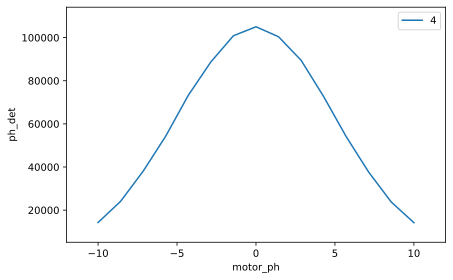

In [16]:
plt.gcf()  # Display a snapshot of the current state of the figure.

### Simulators

Bluesky includes utilities to inspecting plans before they are run. You can imagine various reasons you might want to do this. Example:

In [17]:
from bluesky.simulators import summarize_plan

summarize_plan(scan([det], motor, -1, 1, 3))

=================================== Open Run ===================================
motor_ph -> -1.0
  Read ['ph', 'motor_ph']
motor_ph -> 0.0
  Read ['ph', 'motor_ph']
motor_ph -> 1.0
  Read ['ph', 'motor_ph']
================================== Close Run ===================================


### Custom plan

Define a custom "plan", using the Python syntax ``yield from`` to dispatch out to built-in plans.

In [18]:
plt.gcf().canvas  # To avoid needing to scroll up, display the interactive canvas again here.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
# The plan_stubs module contains smaller plans.
# They can be used alone or as buildling blocks for larger plans.
from bluesky.plan_stubs import mv


def sweep_exposure_time(times):
    "Multiple scans: one per exposure time setting."
    for t in times:
        yield from mv(det.exp, t)
        yield from scan([det], motor, -10, 10, 15)
        
RE(sweep_exposure_time([0.1, 1, 10]))



Transient Scan ID: 5     Time: 2020-05-08 20:55:54
Persistent Unique Scan ID: '425d1966-c70b-4145-a14e-afb2a18b8106'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 20:55:54.4 |    -10.000 |       1364 |
|         2 | 20:55:54.4 |     -8.571 |       2306 |
|         3 | 20:55:54.4 |     -7.143 |       3563 |
|         4 | 20:55:54.4 |     -5.714 |       5352 |
|         5 | 20:55:54.4 |     -4.286 |       7070 |
|         6 | 20:55:54.5 |     -2.857 |       8529 |


|         7 | 20:55:54.5 |     -1.429 |       9475 |
|         8 | 20:55:54.5 |      0.000 |      10014 |


|         9 | 20:55:54.6 |      1.429 |       9486 |
|        10 | 20:55:54.6 |      2.857 |       8436 |
|        11 | 20:55:54.6 |      4.286 |       6729 |
|        12 | 20:55:54.6 |      5.714 |       5139 |
|        13 | 20:55:54.6 |      7.143 |       3555 |
|        14 | 20:55:54.6 |      8.571 |       2309 |
|        15 | 20:55:54.6 |     10.000 |       1381 |
+-----------+------------+------------+------------+
generator scan ['425d1966'] (scan num: 5)





Transient Scan ID: 6     Time: 2020-05-08 20:55:54
Persistent Unique Scan ID: '172f427d-67c2-4e8c-bfa8-8c56b5dd6bfe'


New stream: 'primary'


+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 20:55:54.8 |    -10.000 |      13357 |
|         2 | 20:55:54.8 |     -8.571 |      22483 |
|         3 | 20:55:54.9 |     -7.143 |      35441 |
|         4 | 20:55:54.9 |     -5.714 |      50721 |
|         5 | 20:55:54.9 |     -4.286 |      67446 |
|         6 | 20:55:54.9 |     -2.857 |      82628 |
|         7 | 20:55:54.9 |     -1.429 |      93275 |
|         8 | 20:55:54.9 |      0.000 |      96784 |
|         9 | 20:55:54.9 |      1.429 |      93188 |
|        10 | 20:55:54.9 |      2.857 |      82095 |


|        11 | 20:55:55.0 |      4.286 |      67598 |


|        12 | 20:55:55.0 |      5.714 |      50297 |
|        13 | 20:55:55.1 |      7.143 |      34965 |
|        14 | 20:55:55.1 |      8.571 |      22129 |
|        15 | 20:55:55.1 |     10.000 |      13010 |


+-----------+------------+------------+------------+
generator scan ['172f427d'] (scan num: 6)







Transient Scan ID: 7     Time: 2020-05-08 20:55:55
Persistent Unique Scan ID: '4d01beda-3be7-4f12-a2ce-15bd4c4d8f50'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 20:55:55.3 |    -10.000 |     128699 |
|         2 | 20:55:55.3 |     -8.571 |     219910 |
|         3 | 20:55:55.3 |     -7.143 |     342948 |
|         4 | 20:55:55.3 |     -5.714 |     495345 |
|         5 | 20:55:55.3 |     -4.286 |     658630 |
|         6 | 20:55:55.3 |     -2.857 |     809469 |
|         7 | 20:55:55.3 |     -1.429 |     915078 |


|         8 | 20:55:55.4 |      0.000 |     952131 |


|         9 | 20:55:55.4 |      1.429 |     914411 |
|        10 | 20:55:55.4 |      2.857 |     807385 |
|        11 | 20:55:55.5 |      4.286 |     658206 |
|        12 | 20:55:55.5 |      5.714 |     493435 |
|        13 | 20:55:55.5 |      7.143 |     342532 |
|        14 | 20:55:55.5 |      8.571 |     218107 |
|        15 | 20:55:55.5 |     10.000 |     129200 |
+-----------+------------+------------+------------+
generator scan ['4d01beda'] (scan num: 7)





('425d1966-c70b-4145-a14e-afb2a18b8106',
 '172f427d-67c2-4e8c-bfa8-8c56b5dd6bfe',
 '4d01beda-3be7-4f12-a2ce-15bd4c4d8f50')

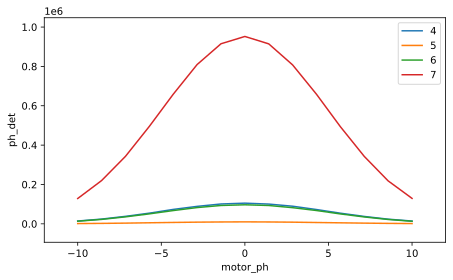

In [20]:
plt.gcf()  # Display a snapshot of the current state of the figure.

## Exercises

Q1: Above we ran a `count` with multiple readings separated by a fixed delay. The ``delay`` parameter also accepts a list of values. Try a `count` with a variable delay.


In [21]:
# Try your solution here. Fill in the blank:
# RE(count(____)))

Execute the following cell to reveal a solution:

In [22]:
%load solutions/count_variable_delay.py

Q2: Write a custom plan that scans the same region twice, first with coarse steps and then with fine steps.

In [23]:
# Try your solution here. Fill in the blank:
# def coarse_and_fine(detectors, motor, start, stop):
#     yield from scan(___)
#     yield from scan(___)
#
# RE(coarse_and_fine([det], motor, -10, 10))

In [24]:
%load solutions/scan_coarse_and_fine.py

Q3. All of the usages of scan we have seen so far scan from negative to positive. Scan from positive to negative.

In [25]:
# Try your solution here.

In [26]:
%load solutions/scan_positive_to_negative.py

Q4: The ``scan`` plan samples equally-spaced points. To sample *arbitrary* points, you can use ``list_scan``. Import it from the same module that we imported ``scan`` from, then use ``list_scan?`` to view its documentation and figure out how to use it. Scan the positions ``[1, 1, 2, 3, 5, 8]``.

In [27]:
# Try your solution here.

In [28]:
%load solutions/scan_fibonacci.py

Q5: What's wrong with this? (What does it do?)

In [29]:
# Broken example
def sweep_exposure_time(times):
    "Multiple scans: one per exposure time setting."
    for t in times:
        mv(det.exposure, t)
        scan([det], motor, -10, 10, 15)

In [30]:
%load solutions/broken_sweep_exposure_time_explanation.txt